In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram
from neuropy.io.usvio import detect_tone

from tracefc.io.session_directory import get_session_dir

In [2]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Rose', 'habituation2'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Rose/2022_06_21_habituation2/Rose_habituation2_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 2745.30 seconds 
duration: 0.76 hours 



## Save notebook to animal working directory

In [5]:
from neuropy.utils.manipulate_files import save_notebook
try:
    save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")
except PermissionError:
    print('Got a weird PermissionError. Check to make sure file saved successfully')

/data/GitHub/TraceFC/Notebooks/Animal_files/Sync_USV_and_Ephys(Rose_habituation2).ipynb saved to /data2/Trace_FC/Recording_Rats/Rose/2022_06_21_habituation2/Rose_habituation2_Sync_USV_and_Ephys(Rose_habituation2).ipynb


### Load in disconnect and motion artifacts

In [6]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=31), thresh=11, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 11.6 seconds


/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,start,stop,label,duration
0,29.9300,30.4324,,0.5024
1,307.6444,308.2116,,0.5672
2,423.4812,423.9852,,0.5040
3,1284.8556,1290.1612,,5.3056
4,1627.3924,1627.9908,,0.5984
5,1712.3548,1713.0612,,0.7064
6,1878.7924,1879.4380,,0.6456
7,2303.7188,2304.2220,,0.5032
8,2311.9708,2312.4772,,0.5064
9,2318.2876,2318.7908,,0.5032


<Axes: >

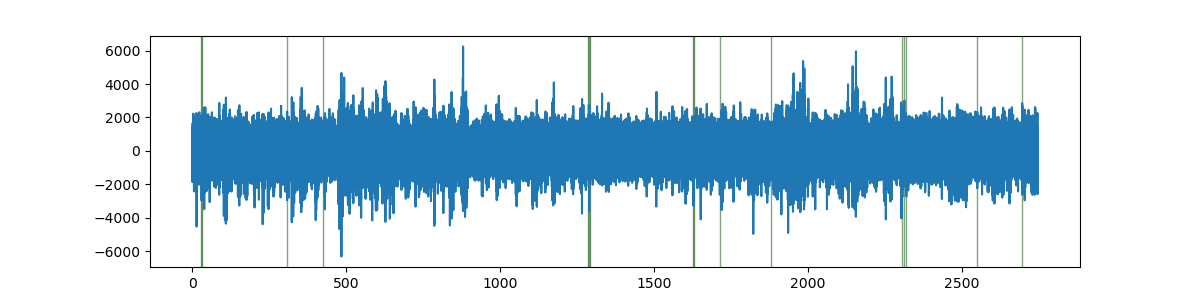

In [7]:
%matplotlib widget

chan_plot = 25
plot_signal_w_epochs(signal, chan_plot, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Rose/2022_06_21_habituation2/Rose_habituation2_denoised.probegroup.npy saved


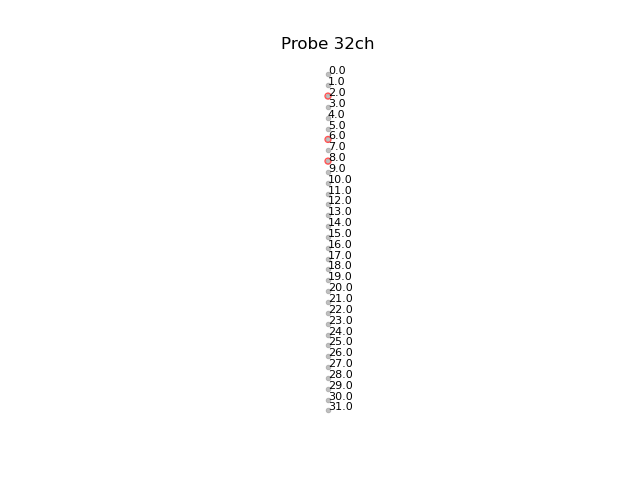

In [8]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

## Detect Theta epochs

In [9]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 24

# # use this if you don't know theta channel
# if theta_channel is None:
#     theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
#                                                     edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
# else:
#     signal_use = signal.time_slice(channel_id=theta_channel)
#     theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
#                                                     edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for theta: [24]
189 epochs remaining with durations within (1,20)


## Detect SWR Epochs

In [10]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 24
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)


Selected channels for ripples: [24]
2441 epochs remaining with durations within (0.05,0.45)


In [11]:
#Detect Delta
from neuropy.analyses.oscillations import detect_hpc_delta_wave_epochs
freq_band = (0.5, 4)
min_dur = 0.15  
max_dur = 0.5   
ignore_epochs = None  
delta_channel = 24

if delta_channel is not None:
    signal_use = signal.time_slice(channel_id=delta_channel)
else:
    signal_use = signal
delta_epochs = detect_hpc_delta_wave_epochs(
    signal_use, freq_band=freq_band, min_dur=min_dur, max_dur=max_dur, ignore_epochs=ignore_epochs
)

930 delta waves detected


In [12]:
#Detect Beta
from neuropy.analyses.oscillations import detect_beta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
beta_channel = 24
  
if beta_channel is None:
    beta_epochs, beta_power = detect_beta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=beta_channel)
    beta_epochs, beta_power = detect_beta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for beta: [24]
191 epochs remaining with durations within (1,20)


In [13]:
# Detect Gamma
from neuropy.analyses.oscillations import detect_gamma_epochs
from neuropy.analyses.oscillations import Gamma
band=(40, 80)
lowthresh = 1.5  
highthresh = 3 
minDistance = 300
minDuration = 125
gamma_channel = 24

# Use this if you don't know the specific channel for gamma detection
if gamma_channel is None:
    signal_use = signal.time_slice(channel_id=gamma_channel)
else:
    # If a specific channel for gamma is known
    signal_use = signal

gammadetect = Gamma()
# gammadetect.get_peak_intervals(signal.traces, lowthresh=lowthresh, highthresh=highthresh, minDistance=minDistance, minDuration=minDuration)
peakevents, gamma_amp = Gamma().get_peak_intervals(signal_use.traces[gamma_channel, :], band=band, lowthresh=lowthresh, highthresh=highthresh, 
                                        minDistance=minDistance, minDuration=minDuration, return_amplitude=True)
# csd=csd(self, period, refchan, band=band, window=1250)
gamma_epochs = Epoch(pd.DataFrame({"start" : peakevents[:, 0]/sess.eegfile.sampling_rate, "stop": peakevents[:, 1]/sess.eegfile.sampling_rate,
                   "label": ""}))
# pd.DataFrame(dict(start=peakevents[:, 0]/sess.eegfile.sampling_rate, stop=peakevents[:, 1]/sess.eegfile.sampling_rate))

## Sync via CS+ or CS- times in tone_recall or control_tone_recall or tone_habituation session

,channel_states,timestamps,datetimes,event_name
913,2,2973453,2022-06-21 12:05:42.115100000,
1061,-2,3271015,2022-06-21 12:05:52.033833333,
2087,2,5341183,2022-06-21 12:07:01.039433333,
2235,-2,5639201,2022-06-21 12:07:10.973366667,
3275,2,7739780,2022-06-21 12:08:20.992666667,


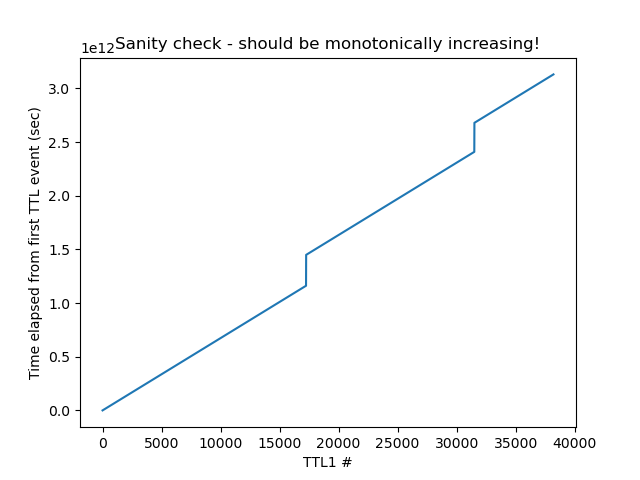

In [14]:
# Load in ttl events from OpenEphys
trace_sync.load_ttls()

In [15]:
sess.basepath

PosixPath('/data2/Trace_FC/Recording_Rats/Rose/2022_06_21_habituation2')

In [16]:
import tracefc.io.traceio as traceio
csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
print(f'{csn_starts.shape[0]} CS- events detected')
print(csn_starts)
print(csn_stops)

15 CS- events detected
       Time (s)       Event                     Timestamp
5     61.610162   CS1_start 2022-06-21 12:05:42.707246543
7    140.533924   CS2_start 2022-06-21 12:07:01.631008864
9    220.486373   CS3_start 2022-06-21 12:08:21.583457948
11   291.306638   CS4_start 2022-06-21 12:09:32.403722526
13   351.964030   CS5_start 2022-06-21 12:10:33.061115027
15   431.917016   CS6_start 2022-06-21 12:11:53.014100553
17   504.766397   CS7_start 2022-06-21 12:13:05.863481761
19   572.510543   CS8_start 2022-06-21 12:14:13.607628345
21   648.419740   CS9_start 2022-06-21 12:15:29.516825200
23   716.194658  CS10_start 2022-06-21 12:16:37.291743279
25   791.043422  CS11_start 2022-06-21 12:17:52.140507222
27   863.892355  CS12_start 2022-06-21 12:19:04.989440204
29   936.742306  CS13_start 2022-06-21 12:20:17.839390994
31  1002.457895  CS14_start 2022-06-21 12:21:23.554979802
33  1071.249135  CS15_start 2022-06-21 12:22:32.346220494
       Time (s)     Event                     Tim

In [17]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2022-06-21 12:04:03.612859-04:00
start time = 2022-06-21 12:28:38.214630-04:00
start time = 2022-06-21 12:48:43.734492-04:00


Recording                            Datetime Condition  nframe_dat  \
0          0    2022-06-21 12:04:03.612859-04:00     start           0   
1          0 2022-06-21 12:25:10.113092332-04:00      stop    37995007   
2          1    2022-06-21 12:28:38.214630-04:00     start    37995008   
3          1 2022-06-21 12:44:59.838063333-04:00      stop    67443711   
4          2    2022-06-21 12:48:43.734492-04:00     start    67443712   
5          2 2022-06-21 12:57:00.912058667-04:00      stop    82359039   

      dat_time  nframe_eeg   eeg_time  
0     0.000000           0     0.0000  
1  1266.500233     1583125  1266.5000  
2  1266.500267     1583126  1266.5008  
3  2248.123700     2810154  2248.1232  
4  2248.123733     2810155  2248.1240  
5  2745.301300     3431626  2745.3008

In [18]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = pd.Timedelta(0.8, unit="seconds")
csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)
csn_oe_stop_df = traceio.trace_ttl_to_openephys(csn_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)
csn_stops_combined = oeio.recording_events_to_combined_time(csn_oe_stop_df, sync_df)

start time lag: mean = -0.5874868063333333, std = 0.002966479872378818
start time lag: mean = -0.5877472923333333, std = 0.0029689717343285554


/data/GitHub/TraceFC/tracefc/io/traceio.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace_cs_sync_df.loc[:, "datetimes"] = trace_cs_sync_df["datetimes"].dt.tz_localize(


In [19]:
csn_starts_combined

array([  98.502241,  177.426574,  257.379807,  328.200774,  388.858741,
        468.812441,  541.662507,  609.407307,  685.317307,  753.092674,
        827.942141,  900.791807,  973.642374, 1039.358507, 1108.150474])

In [20]:
csn_starts

,Time (s),Event,Timestamp
5,61.610162,CS1_start,2022-06-21 12:05:42.707246543
7,140.533924,CS2_start,2022-06-21 12:07:01.631008864
9,220.486373,CS3_start,2022-06-21 12:08:21.583457948
11,291.306638,CS4_start,2022-06-21 12:09:32.403722526
13,351.964030,CS5_start,2022-06-21 12:10:33.061115027
15,431.917016,CS6_start,2022-06-21 12:11:53.014100553
17,504.766397,CS7_start,2022-06-21 12:13:05.863481761
19,572.510543,CS8_start,2022-06-21 12:14:13.607628345
21,648.419740,CS9_start,2022-06-21 12:15:29.516825200
23,716.194658,CS10_start,2022-06-21 12:16:37.291743279


In [21]:
csn_stops

,Time (s),Event,Timestamp
6,71.529510,CS1_end,2022-06-21 12:05:52.626594544
8,150.468150,CS2_end,2022-06-21 12:07:11.565234900
10,230.426551,CS3_end,2022-06-21 12:08:31.523636104
12,301.225990,CS4_end,2022-06-21 12:09:42.323075057
14,361.904710,CS5_end,2022-06-21 12:10:43.001795054
16,441.853727,CS6_end,2022-06-21 12:12:02.950812341
18,514.682277,CS7_end,2022-06-21 12:13:15.779361964
20,582.451229,CS8_end,2022-06-21 12:14:23.548314095
22,658.360426,CS9_end,2022-06-21 12:15:39.457510949
24,726.109055,CS10_end,2022-06-21 12:16:47.206140042


In [22]:
csn_oe_start_df

,channel_states,timestamps,datetimes,event_name
913,2,2973453,2022-06-21 12:05:42.115100-04:00,
2087,2,5341183,2022-06-21 12:07:01.039433333-04:00,
3275,2,7739780,2022-06-21 12:08:20.992666667-04:00,
4328,2,9864409,2022-06-21 12:09:31.813633333-04:00,
5231,2,11684148,2022-06-21 12:10:32.471600-04:00,
6419,2,14082759,2022-06-21 12:11:52.425300-04:00,
7502,2,16268261,2022-06-21 12:13:05.275366667-04:00,
8510,2,18300605,2022-06-21 12:14:13.020166667-04:00,
9639,2,20577905,2022-06-21 12:15:28.930166667-04:00,
10646,2,22611166,2022-06-21 12:16:36.705533333-04:00,


### How to write CS+ to neuroscope event file

In [23]:
csn_tone_recall_epochs = Epoch({"start": csn_starts_combined, "stop": csn_stops_combined, "label": ["CS-"]*len(csn_starts_combined)})
csn_tone_recall_epochs
sess.recinfo.write_epochs(csn_tone_recall_epochs, "CS-")

In [24]:
# Detect CS+ in audio recording.
#from tracefc.io.traceio import grab_usv_folder
#csp_wav = grab_usv_folder(sess.basepath, 'csp')
#print(csp_wav)
## Get CS+ times and plot to check
#cs_wav_epochs, cs_wav_stop = detect_tone(csp_wav, freq_lims=(6900, 7100), thresh=0.05, tone_length=10, tone_label="CS+", 
#                                         plot_check=True, return_stop=True)
## Check that lags are consistent
#cs_start_lags = cs_starts_combined - cs_wav_epochs.starts
#print(f"Mean start lag time of {np.mean(cs_start_lags):0.3F} sec with std = {np.std(cs_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
#cs_stop_lags = cs_stops_combined - cs_wav_epochs.stops
#print(f"Mean stop lag time of {np.mean(cs_stop_lags):0.3F} sec with std = {np.std(cs_stop_lags):0.3F} sec.")

Ditto for CS-

/data2/Trace_FC/Recording_Rats/Rose/2022_06_21_habituation2/1_tone_habituation/tone_habit_restbox/T0000001.wav
Mean start lag time of 19.158 sec with std = 0.044 sec. Add lags from wavfile times to get ephys times
Mean stop lag time of 18.822 sec with std = 0.074 sec.


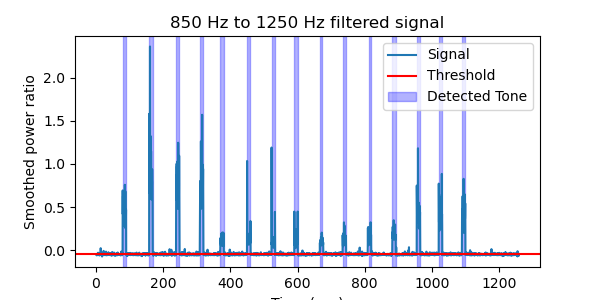

In [25]:
# Detect CS- in audio recording.
from tracefc.io.traceio import grab_usv_folder
csn_wav = grab_usv_folder(sess.basepath, 'csn')
print(csn_wav)
# Get CS+ times and plot to check
csn_wav_epochs, csn_wav_stop = detect_tone(csn_wav, freq_lims=(850, 1250), thresh=-0.04, tone_length=8, tone_label="CS-", 
                                         plot_check=True,
                                           return_stop=True)


csn_wav_epochs.stops[5] = 460.0 
csn_wav_epochs.stops[8] = 676.45
csn_wav_epochs.starts[10] = 808.8

## Check that lags are consistent
csn_start_lags = csn_starts_combined - csn_wav_epochs.starts
print(f"Mean start lag time of {np.mean(csn_start_lags):0.3F} sec with std = {np.std(csn_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
csn_stop_lags = csn_stops_combined - csn_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(csn_stop_lags):0.3F} sec with std = {np.std(csn_stop_lags):0.3F} sec.")

Now try to sync to start tone 

In [26]:
#no_tone_wave = grab_usv_folder(sess.basepath, "sync")
#print(no_tone_wav)

# Get CS+ times and plot to check
#start_wav_epochs, start_wav_stop = detect_tone(no_tone_wav, freq_lims=(450, 550), thresh=3, tone_length=0.5, tone_label="start_tone", 
                               #plot_check=True, return_stop=True)

## Sync recorded USV times to ephys file

In [27]:
sess.basepath

PosixPath('/data2/Trace_FC/Recording_Rats/Rose/2022_06_21_habituation2')

In [28]:
csn_wav

PosixPath('/data2/Trace_FC/Recording_Rats/Rose/2022_06_21_habituation2/1_tone_habituation/tone_habit_restbox/T0000001.wav')

In [29]:
# Read in USV times from tone recall session
from neuropy.io.usvio import DeepSqueakIO
usv_detect_file = sorted(Path(csn_wav).parent.glob(f"**/{Path(csn_wav).name[:-4]}*_cell.mat"))[0]
ds_calls = DeepSqueakIO(filename=usv_detect_file)
ds_calls.load_calls()
ds_calls.usv_df.sample(5)

,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept
3,10.329296,42.194005,0.049649,10.772624,1,1
10,131.284778,45.098982,0.062763,15.009050,1,1
18,1047.546136,42.194005,0.057143,7.020362,1,1
16,287.954905,40.983597,0.033724,10.893665,1,1
8,77.917205,43.404412,0.060890,12.225113,1,1


Plot lags vs time to check for drift between ephys and audio recordings and correct if necessary

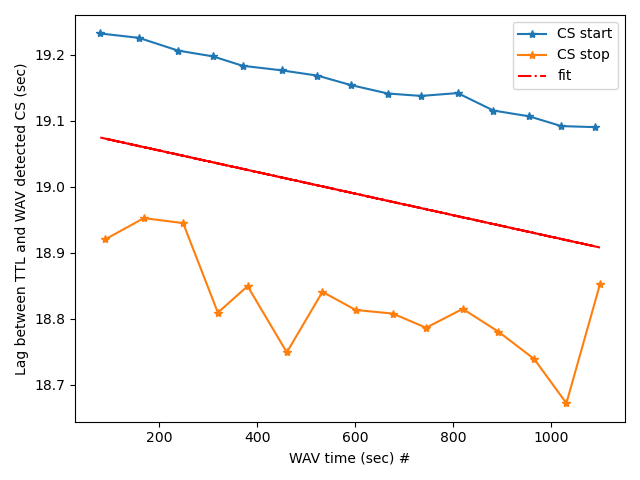

In [30]:
from scipy.linalg import lstsq

_, ax = plt.subplots(layout='tight')
csn_times_wav = np.stack((csn_wav_epochs.starts, csn_wav_epochs.stops), axis=1)
csn_lags_comb = np.stack((csn_start_lags, csn_stop_lags), axis=1)
hl = ax.plot(csn_times_wav, csn_lags_comb, '*-')
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = csn_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(csn_lags_comb.reshape(-1)), csn_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
hfit = ax.plot(csn_times_wav.T.reshape(-1), p[0] + p[1]*csn_times_wav.T.reshape(-1), 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [31]:
# Sanity check code to output corrected CS times from WAV file to Neuroscope
csn_wav_starts_aligned = csn_wav_epochs.starts + p[0] + p[1]*csn_wav_epochs.starts
csn_wav_stops_aligned = csn_wav_epochs.stops + p[0] + p[1]*csn_wav_epochs.stops
csn_wav_epochs_aligned = Epoch({"start": csn_wav_starts_aligned, "stop": csn_wav_stops_aligned, 
                               "label": ["CS+ from WAV file"]*len(csn_wav_stops_aligned)})


csn_epochs_files = sess.filePrefix.with_suffix(".csn_wav_epochs.npy")
csn_wav_epochs_aligned.save(csn_epochs_files)
sess.recinfo.write_epochs(csn_wav_epochs_aligned, ext="wv+")

/data2/Trace_FC/Recording_Rats/Rose/2022_06_21_habituation2/Rose_habituation2_denoised.csn_wav_epochs.npy saved


## Now correct that drift and find corrected lags!

In [32]:
# This should eventually be folded into the DeepSqueakIO class!
# Bowen question: 
calls_accept_df = ds_calls.usv_df[ds_calls.usv_df['Accept'] == 1]
call_starts_wav = calls_accept_df['Begin_Time'].values
call_stops_wav = call_starts_wav + calls_accept_df['Duration'].values
calls_accept_df.insert(0, "start", call_starts_wav + p[0] + p[1]*call_starts_wav)
calls_accept_df.insert(1, "stop", call_stops_wav + p[0] + p[1]*call_stops_wav)
calls_accept_df.insert(calls_accept_df.shape[1], "label", "")
good_calls = Epoch(calls_accept_df)

# output to neuroscope and neuropy
sess.recinfo.write_epochs(good_calls, ext="usv")
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
good_calls.save(usv_epochs_file)

/data2/Trace_FC/Recording_Rats/Rose/2022_06_21_habituation2/Rose_habituation2_denoised.usv_epochs.npy saved


In [33]:
good_calls

22 epochs
Snippet: 
        start       stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  21.903809  21.940337    2.816586  37.352376  0.036534   14.403846      1   
1  23.099961  23.159905    4.012934  43.041290  0.059953   27.113122      1   
2  28.500217  28.552668    9.414074  42.920249  0.052459    9.320136      1   
3  29.415290  29.464931   10.329296  42.194005  0.049649   10.772624      1   
4  64.723776  64.783719   45.643560  40.015271  0.059953   23.845023      1   

   Accept label  
0       1        
1       1        
2       1        
3       1        
4       1        

## Save notebook to working directory

In [34]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)